# Knowledge distillation
In this notebook, we will try to distill the knowledge of a Vision Transformer into a MLP Mixer.

##0. Downloads and imports

In [ ]:
#@title Downloads
!pip install -q transformers datasets[vision] pytorch-lightning
!pip install einops

     |████████████████████████████████| 5.5 MB 9.5 MB/s 
     |████████████████████████████████| 451 kB 57.1 MB/s 
     |████████████████████████████████| 798 kB 48.8 MB/s 
     |████████████████████████████████| 7.6 MB 54.9 MB/s 
     |████████████████████████████████| 182 kB 72.2 MB/s 
     |████████████████████████████████| 529 kB 69.6 MB/s 
     |████████████████████████████████| 125 kB 65.7 MB/s 
     |████████████████████████████████| 87 kB 6.3 MB/s 
     |████████████████████████████████| 115 kB 66.3 MB/s 
     |████████████████████████████████| 212 kB 74.2 MB/s 
     |████████████████████████████████| 127 kB 71.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 440 kB/s 


In [ ]:
#@title Imports

# general imports
from typing import *
from google.colab import drive
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# pytorch imports
import torchvision
import transformers
#from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
import numpy as np
import einops
import torch.nn as nn
import torch.nn.functional as F

device : str = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#@title Move to the project folder
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive

if not os.path.exists("ViT2MLP"):
  os.mkdir("ViT2MLP")

%cd ViT2MLP

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/ViT2MLP


In [ ]:
#@title Download the datasets
# TODO need to download it
#imagenet = torchvision.datasets.ImageNet(root = ".",split = "val")

cifar100 = torchvision.datasets.CIFAR100(root = ".", train = False, download = True)

Files already downloaded and verified


In [ ]:
#@title Visualization function
def visualize(datapoint : int, dataset : torchvision.datasets):
    image, label = dataset[datapoint]
    plt.title(f"Ground truth: {dataset.classes[label]}")
    plt.imshow(image)

##1. Code for the pre-trained transformer

References:
- [main transformer docs](https:huggingface.co/docs/transformers/index) 
- [ViT Docs](https://huggingface.co/docs/transformers/model_doc/vit)
- [lighting finetuning example](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer)

### Example of transformer model

Load ViT finetuned on Imagenet1k or CIFAR100. To load the non fine-tuned version use **"google/vit-base-patch16-224-im21k"**

In [ ]:
#@title Load the model
cifar100_vit = "Ahmed9275/Vit-Cifar100"
imagenet1k_vit = "google/vit-base-patch16-224"
tuned_on : str = "cifar100" #@param['cifar100', 'imagenet1k']
if tuned_on == "cifar100":
    model_str = cifar100_vit
else:
    model_str = imagenet1k_vit


feature_extractor = transformers.ViTFeatureExtractor.from_pretrained(model_str)

model = transformers.ViTForImageClassification.from_pretrained(model_str).to(device)

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.68k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344M [00:00<?, ?B/s]

In [ ]:
#@title Function to predict
def predict(image, only_label : bool = False) -> str:
    inputs = feature_extractor(image, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    # model predicts one of the 1000 ImageNet classes
    predicted_label : int = logits.argmax(-1).item()
    if only_label:
        return predicted_label
    return model.config.id2label[predicted_label]


Predicted: train


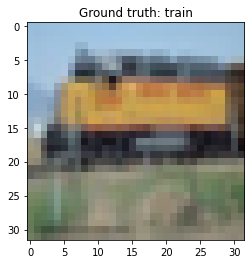

In [ ]:
#@title Qualitative comparison with ground truth {run : "auto"}
datapoint_number : int = 9985 #@param{type:"integer"}

dataset = cifar100 if tuned_on == "cifar100" else imagenet1k
try:
    visualize(datapoint_number, dataset)
    print(f"Predicted: {predict(dataset[datapoint_number][0])}")
except IndexError:
    print(f"The dataset max index is {len(dataset)-1}")


In [ ]:
#@title Quantitative result: Accuracy
correct = 0
for i in tqdm(range(len(dataset))):
    pr_label = predict(dataset[i][0], only_label=True)
    gt_label = dataset[i][1]
    if pr_label == gt_label:
        correct += 1
accuracy = round(correct*100 / len(dataset),2)
print(f"The accuracy of the model for the dataset {tuned_on} is: {accuracy}%")

100%|██████████| 10000/10000 [03:01<00:00, 55.03it/s]


The accuracy of the model for the dataset cifar100 is: 89.85%


##2. Code for MLP mixer

In [ ]:
#tentative pytorch implementation for https://github.com/google-research/vision_transformer/blob/main/vit_jax/models_mixer.py
#to include: apache license lol

class MlpBlock(nn.Module):

  #TODO: implement with sequential
  def __init__(self, mlp_dim):
    super().__init__()
    #dense implementation only has out features specified, need to check input dim
    self.mlp1 = nn.Linear(in_features=mlp_dim, out_features = mlp_dim)
    self.mlp2 = nn.Linear(in_features=mlp_dim, out_features = mlp_dim)
    self.activation = F.gelu

  def forward(self, x):
    y = self.mlp1(x)
    y = self.activation(y)
    y = self.mlp2(y)
    return y

class MixerBlock(nn.Module):

  #TODO:??
  def __init__(self, tokens_mlp_dim, channels_mlp_dim):
    super().__init__()
    self.layer_norm = F.layer_norm
    self.mlpblock_token_mixer = MlpBlock(tokens_mlp_dim)
    self.mlpblock_channel_mixer = MlpBlock(channels_mlp_dim)

  def forward(self,x):
    y = self.layer_norm(x)
    y = np.swapaxes(y,1,2)
    y = self.mlpblock_token_mixer(y)
    y = np.swapaxes(y,1,2)
    x = x + y
    y = self.layer_norm(x)
    return x + self.mlpblock_channel_mixer(y)

class MlpMixer(nn.Module):
  """Mixer architecture"""

  def __init__(self, hidden_dim : int, patches : Any,
               num_blocks: int, tokens_mlp_dim : int,
               channels_mlp_dim : int, num_classes: int):
    self.hidden_dim = hidden_dim
    self.patches = patches
    self.num_blocks = num_blocks
    self.num_classes = num_classes
    #per patch fully connected?
    self.stem = nn.Conv2d(in_channels = self.hidden_dim, out_channels = self.patches.size,
                  stride = self.patches.size)
    self.mixer_block = MixerBlock(self.tokens_mlp_dim, self.channels_mlp_dim)
    self.layer_norm = F.layer_norm
    #What is kernel init? Does it initialize everything to 0?
    self.fc = nn.Linear(input_features = self.channels_mlp_dim, output_features = self.num_classes)

  #what is * ?
  def forward(self, inputs, *, train):
    #why delete train?
    del train
    x = self.stem(x)
    x = einops.rearrange(x, 'n h w c -> n (h w) c')
    for _ in range(self.num_blocks):
      x = self.mixer_block(x)
    x = self.layer_norm(x)
    x = np.mean(x, axis = 1)
    if self.num_classes:
      #add classification layer if num classes is specified
      x = self.fc(x)
    return x